# Testing bilateral symmetry - semiparametric test

## Preliminaries

In [1]:
import datetime
import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from giskard.plot import scatterplot
from graspologic.inference import latent_position_test
from graspologic.utils import binarize, multigraph_lcc_intersection, symmetrize
from pkg.data import load_adjacency, load_node_meta
from pkg.io import get_out_dir, savefig
from pkg.plot import set_theme
from pkg.utils import get_paired_inds, get_paired_subgraphs, set_warnings

# from src.visualization import adjplot  # TODO fix graspologic version and replace here

set_warnings()


t0 = time.time()

RECOMPUTE = False

foldername = "semipar"


def stashfig(name, **kwargs):
    savefig(name, foldername=foldername, **kwargs)


out_dir = get_out_dir(foldername=foldername)

colors = sns.color_palette("Set1")
palette = dict(zip(["Left", "Right"], colors))
set_theme()

/Users/bpedigo/miniconda3/envs/maggot-revamp/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## Load the data

### Load node metadata and select the subgraphs of interest

In [2]:
meta = load_node_meta()
meta = meta[meta["paper_clustered_neurons"]]

adj = load_adjacency(graph_type="G", nodelist=meta.index)

lp_inds, rp_inds = get_paired_inds(meta)
left_meta = meta.iloc[lp_inds]
right_meta = meta.iloc[rp_inds]

ll_adj, rr_adj, lr_adj, rl_adj = get_paired_subgraphs(adj, lp_inds, rp_inds)

# TODO not sure what we wanna do about LCCs here
adjs, lcc_inds = multigraph_lcc_intersection([ll_adj, rr_adj], return_inds=True)
ll_adj = adjs[0]
rr_adj = adjs[1]
print(f"{len(lcc_inds)} in intersection of largest connected components.")

print(f"Original number of valid pairs: {len(lp_inds)}")

left_meta = left_meta.iloc[lcc_inds]
right_meta = right_meta.iloc[lcc_inds]
meta = pd.concat((left_meta, right_meta))
n_pairs = len(ll_adj)

print(f"Number of pairs after taking LCC intersection: {n_pairs}")

1210 in intersection of largest connected components.
Original number of valid pairs: 1211
Number of pairs after taking LCC intersection: 1210


## Run a latent position test

In [3]:
if RECOMPUTE:
    preprocess = [symmetrize, binarize]
    graphs = [ll_adj, rr_adj]

    for func in preprocess:
        for i, graph in enumerate(graphs):
            graphs[i] = func(graph)

    ll_adj = graphs[0]
    rr_adj = graphs[1]
    n_bootstraps = 200
    test_case = "rotation"
    embedding = "ase"
    verbose = 1
    workers = -2
    rows = []
    for embedding in ["ase", "omnibus"]:
        for n_components in np.arange(6, 15):
            currtime = time.time()
            params = dict(
                embedding=embedding,
                n_components=n_components,
                test_case=test_case,
                n_bootstraps=n_bootstraps,
                workers=workers,
            )
            pvalue, tstat, misc = latent_position_test(ll_adj, rr_adj, **params)
            elapsed = time.time() - currtime

            row = params.copy()
            row["pvalue"] = pvalue
            row["tstat"] = tstat
            rows.append(row)
            results = pd.DataFrame(rows)
            results.to_csv(out_dir / "semipar_results")
            if verbose > 0:
                pprint.pprint(row)
                print()

In [4]:
results = pd.read_csv(out_dir / "semipar_results", index_col=0)

## Plot p-values

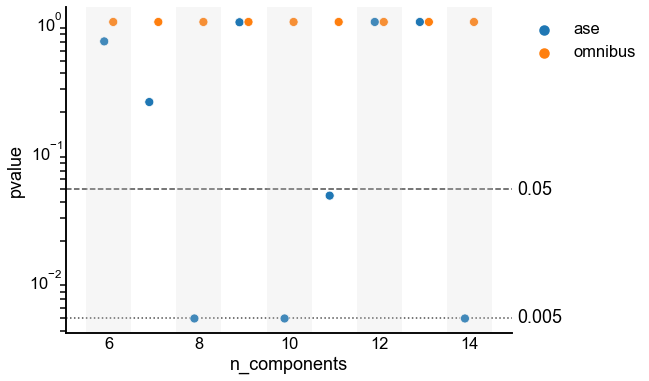

In [5]:
ax = scatterplot(
    data=results,
    x="n_components",
    y="pvalue",
    hue="embedding",
    shift="embedding",
    shade=True,
)
ax.set_yscale("log")
styles = ["--", ":"]
line_locs = [0.05, 0.005]
line_kws = dict(color="black", alpha=0.7, linewidth=1.5, zorder=-1)
for loc, style in zip(line_locs, styles):
    ax.axhline(loc, linestyle=style, **line_kws)
    ax.text(ax.get_xlim()[-1] + 0.1, loc, loc, ha="left", va="center")
stashfig("semipar-pvalues-by-dimension")

# #%%
# test_case = "rotation"
# embedding = "omnibus"
# n_components = 8
# n_bootstraps = 100
# n_repeats = 5
# rows = []
# for n_shuffle in [4, 8, 16]:

#     for repeat in range(n_repeats):
#         inds = np.arange(len(rr_adj))
#         choice_inds = np.random.choice(len(rr_adj), size=n_shuffle, replace=False)
#         shuffle_inds = choice_inds.copy()
#         np.random.shuffle(shuffle_inds)
#         inds[choice_inds] = inds[shuffle_inds]
#         rr_adj_shuffle = rr_adj[np.ix_(inds, inds)]
#         currtime = time.time()
#         pvalue, tstat, misc = latent_position_test(
#             ll_adj,
#             rr_adj_shuffle,
#             embedding=embedding,
#             n_components=n_components,
#             test_case=test_case,
#             n_bootstraps=n_bootstraps,
#         )
#         row = {
#             "pvalue": pvalue,
#             "tstat": tstat,
#             "n_shuffle": n_shuffle,
#             "n_components": n_components,
#             "n_bootstraps": n_bootstraps,
#             "embedding": embedding,
#             "test_case": test_case,
#             "repeat": repeat,
#         }
#         rows.append(row)
#         print(f"{time.time() - currtime:.3f} seconds elapsed.")
#         print(f"n_shuffle: {n_shuffle}")
#         print(f"test case: {test_case}")
#         print(f"embedding: {embedding}")
#         print(f"n_components: {n_components}")
#         print(f"p-value: {pvalue}")
#         print(f"tstat: {tstat}")
#         print()

# #%%
# results = pd.DataFrame(rows)
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.scatterplot(data=results, x="n_shuffle", y="pvalue", ax=ax)
# stashfig("shuffle-p-values")

## End

In [6]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:00:02.892378
Completed at 2021-04-27 12:59:46.906761
----
